In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
import torchvision.utils as utils
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter
from mean_average_precision import MetricBuilder


from wsddn import *

In [2]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set = CustomVOC('../edge_boxes_model/model.yml.gz', root='../../../data', image_set='train', download=False, transform=transform_train)
test_set = CustomVOC('../edge_boxes_model/model.yml.gz', eval_mode=True, root='../../../data', image_set='val', download=False, transform=transform_test)

def my_collate(batch):
    data = [item[0] for item in batch]
    label = [item[1] for item in batch]
    boxes = [item[2] for item in batch]
    if (len(batch[0]) == 4):
        gt_boxes = [item[3] for item in batch]
        return data, label, boxes, gt_boxes
    return data, label, boxes

train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=0, collate_fn=my_collate)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0, collate_fn=my_collate)

In [3]:
torch.cuda.is_available()

True

In [6]:
# %env CUDA_LAUNCH_BLOCKING=1

In [7]:
model = WSDDN(21)
model = model.cuda()
optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9, weight_decay=5e-4)
# scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7, 10, 50], gamma=0.1)

In [8]:
attempt = 5

In [9]:
# attempt += 1
step = 0
log_freq = 60
epochs = 100
save_freq = 10
num_eval_images = 25 # Only run eval on this many images
run_name = 'wsddn_attempt_%s'%attempt
checkpoints_folder = './checkpoints/%s/'%run_name
if not os.path.isdir(checkpoints_folder):
    os.mkdir(checkpoints_folder)
writer = SummaryWriter('./runs/' + run_name)
for epoch in range(epochs + 1):
    # adjust learning rate
    # scheduler.step()
    print("\nepoch %d learning rate %f\n" % (epoch, optimizer.param_groups[0]['lr']))
    # run for one epoch
    for i, stacked_data in enumerate(train_loader):
        model.train()

        # optimizer.zero_grad()
        # model.zero_grad()
        # batch_loss = 0
        for data in zip(stacked_data[0], stacked_data[1], stacked_data[2]):
            optimizer.zero_grad()
            model.zero_grad()
        
            image, label, boxes = data
            image = image.reshape([1, image.shape[0], image.shape[1], image.shape[2]])

            image, label, boxes = image.cuda(), label.cuda(), boxes.cuda()

            # forward
            pred, x = model.forward(image, boxes)

            # backward
            loss = model.loss(pred, label)# + model.reg(pred, x, boxes)

            loss.backward()
            optimizer.step()

            # batch_loss += loss
            
        # batch_loss.backward()
        # optimizer.step()

        # display results
        if i % log_freq == 0:
            writer.add_scalar('train/loss', loss.item(), step)
            print("[epoch %d][%d/%d] loss %.4f"%(epoch, i, len(train_loader)-1, loss.item()))

        # global step
        step += 1

    if epoch % save_freq == 0 and epoch > 0:
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }, 
            '%s/wsdnn_epoch_%s.pth' % (checkpoints_folder, epoch)
        )

    print('-'*40)
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        metric_fn = MetricBuilder.build_evaluation_metric("map_2d", num_classes=21)
        # log scalars
        for i, stacked_data in enumerate(test_loader):
            for data in zip(stacked_data[0], stacked_data[1], stacked_data[2], stacked_data[3]):
                image_test, _, boxes_test, gt_boxes = data
                image_test = image_test.reshape([1, image_test.shape[0], image_test.shape[1], image_test.shape[2]])

                image_test, boxes_test = image_test.cuda(), boxes_test.cuda()

                detections = model.detect(image_test, boxes_test)

                formatted_detections = test_set.format_pred(detections)
                # custom_voc_set_eval.draw_boxes(image, formatted_detections, gt_boxes)
                metric_fn.add(np.array(formatted_detections), np.array(gt_boxes))
            
            if i == num_eval_images:
                break


        mAP = metric_fn.value(iou_thresholds=0.5, recall_thresholds=np.arange(0., 1.1, 0.1))['mAP']
        writer.add_scalar('test/mAP', mAP, epoch)
        print("\n[epoch %d] mAP on test data: %.2f%%\n" % (epoch, mAP))
    
    print('-'*40)

] loss 0.5230
[epoch 15][900/5716] loss 0.0515
[epoch 15][960/5716] loss 0.0000
[epoch 15][1020/5716] loss 0.1498
[epoch 15][1080/5716] loss 0.0001
[epoch 15][1140/5716] loss 0.1286
[epoch 15][1200/5716] loss 1.6809
[epoch 15][1260/5716] loss 0.0008
[epoch 15][1320/5716] loss 0.0746
[epoch 15][1380/5716] loss 0.0039
[epoch 15][1440/5716] loss 0.1722
[epoch 15][1500/5716] loss 0.6248
[epoch 15][1560/5716] loss 0.0001
[epoch 15][1620/5716] loss 0.0249
[epoch 15][1680/5716] loss 0.0000
[epoch 15][1740/5716] loss 0.0214
[epoch 15][1800/5716] loss 0.2838
[epoch 15][1860/5716] loss 0.0496
[epoch 15][1920/5716] loss 0.0000
[epoch 15][1980/5716] loss 0.0108
[epoch 15][2040/5716] loss 0.0001
[epoch 15][2100/5716] loss 0.0384
[epoch 15][2160/5716] loss 2.5554
[epoch 15][2220/5716] loss 0.2442
[epoch 15][2280/5716] loss 0.0920
[epoch 15][2340/5716] loss 0.0738
[epoch 15][2400/5716] loss 0.0001
[epoch 15][2460/5716] loss 0.4819
[epoch 15][2520/5716] loss 0.0102
[epoch 15][2580/5716] loss 0.0072
[e

KeyboardInterrupt: 

In [ ]:
# CUDA_LAUNCH_BLOCKING=1

In [21]:
# For visualization, create test set without the normalization
test_vis_set = CustomVOC('../edge_boxes_model/model.yml.gz', eval_mode=True, root='../../../data', image_set='val', download=False)

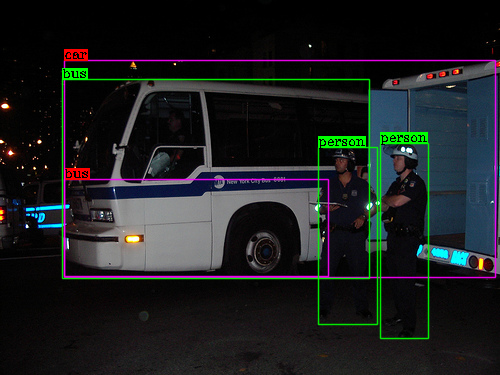

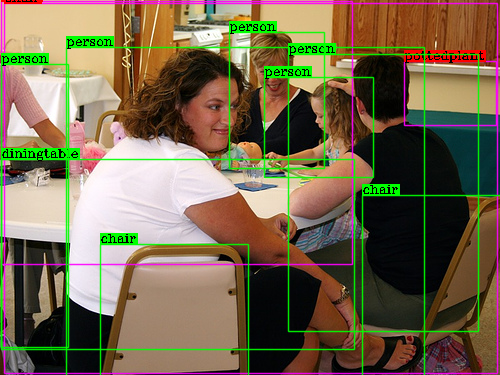

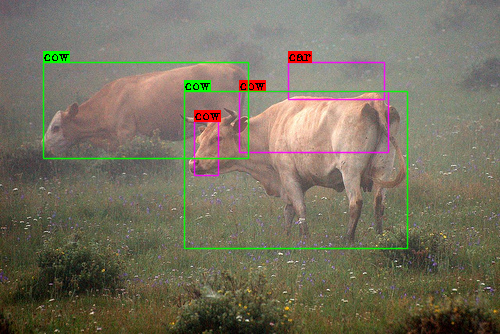

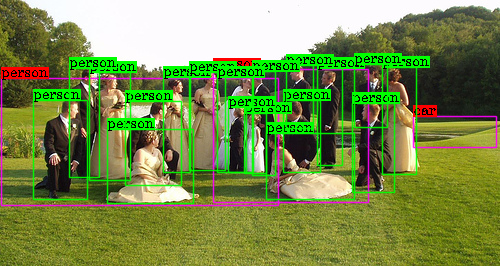

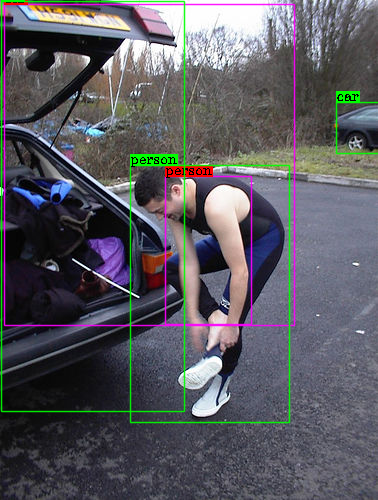

In [39]:
for _ in range(5):
    idx = np.random.randint(len(test_set))
    img, _, _, _ = test_vis_set[idx]
    image, label, boxes, gt_boxes = test_set[idx]
    image = image.reshape([1, image.shape[0], image.shape[1], image.shape[2]])
    image, label, boxes = image.cuda(), label.cuda(), boxes.cuda()
    detections = test_set.format_pred(model.detect(image, boxes))
    display(test_set.draw_boxes(img, detections, gt_boxes))

In [41]:
model.reg(pred, x, boxes)

tensor(1.5385e-07, device='cuda:0', grad_fn=<DivBackward0>)